In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

In [3]:
import addict
import copy
import numpy.matlib
import scipy
import scipy.sparse.linalg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from importlib import reload
from tqdm.notebook import tqdm

import celeri

plt.rcParams['text.usetex'] = False # Plotting the global model is much much faster with tex fonts turned off

# Read data, calculate elastic TDE to station partials and distance weighted smoothing matrix

In [4]:
command_file_name = "../data/western_north_america/basic_command.json"
command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
station = celeri.process_station(station, command)
operators = addict.Dict()
# operators.tri_station = celeri.get_tri_station_operator_okada(meshes, station, command)
operators.tri_station = celeri.get_tde_to_velocities(meshes, station, command)
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Eliminate matrix entries for vertical displacments and tensile slip
tde_matrix = copy.deepcopy(operators.tri_station)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[0], 3), axis=0)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[1], 3), axis=1)

Warning: The file contains tag data that couldn't be processed.

Calculating cutde partials for triangles:   0%|          | 0/1841 [00:00<?, ?it/s]

# Functions used throughout.  Some may eventually go celeri.py

In [5]:
def plot_slip_distributions(mesh, slip_distribution_input, slip_distribution_estimated, suptitle_string):
    triangulation = tri.Triangulation(mesh.centroids[:, 0], mesh.centroids[:, 1])

    levels = np.linspace(-1.0, 1.0, 30)
    vmin = -1.0
    vmax = 1.0
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("input strike-slip")
    tcf = plt.tricontourf(triangulation, slip_distribution_input[0::2], cmap="seismic", levels=levels, vmin=vmin, vmax=vmax, extend="both")
    plt.tricontour(triangulation, slip_distribution_input[0::2], colors="k", linewidths=0.25, levels=levels)
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 2)
    plt.title("estimated strike-slip")
    tcf = plt.tricontourf(triangulation, slip_distribution_estimated[0::2], cmap="seismic", levels=levels, vmin=vmin, vmax=vmax, extend="both")
    plt.tricontour(triangulation, slip_distribution_estimated[0::2], colors="k", linewidths=0.25, levels=levels)
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 3)
    plt.title("input dip-slip")
    tcf = plt.tricontourf(triangulation, slip_distribution_input[1::2], cmap="seismic", levels=levels, vmin=vmin, vmax=vmax, extend="both")
    plt.tricontour(triangulation, slip_distribution_input[1::2], colors="k", linewidths=0.25, levels=levels)
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 4)
    plt.title("estimated dip-slip")
    tcf = plt.tricontourf(triangulation, slip_distribution_estimated[1::2], cmap="seismic", levels=levels, vmin=vmin, vmax=vmax, extend="both")
    plt.tricontour(triangulation, slip_distribution_estimated[1::2], colors="k", linewidths=0.25, levels=levels)
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.suptitle(suptitle_string)
    plt.show()    


def get_synthetic_displacements(mesh, tri_linear_operator):
    """
    Prescribe dip-slip in a Gaussian pattern.
    """
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0])
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    # Hardcoded northern Cascadia example that Jack suggested.
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - 234.5
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - 48.5

    # Southern Cascadia example
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0]) - 2
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])


    tri_centroid_to_mesh_centroid_distance = np.sqrt(tri_centroid_to_mesh_lon ** 2 + tri_centroid_to_mesh_lat ** 2)
    dip_slip_distribution = np.exp(-(tri_centroid_to_mesh_centroid_distance / 1.0) ** 2.0)
    slip_distribution = np.zeros(2 * dip_slip_distribution.size)
    slip_distribution[1::2] = dip_slip_distribution # Dip slip only
    slip_distribution[0::2] = 1e-4 * np.random.randn(dip_slip_distribution.size) # Adding a teeny amount of non-zero noise here just so contouring works...ugh
    synthetic_displacements = tri_linear_operator @ slip_distribution
    return slip_distribution, synthetic_displacements


def show_modes(mesh, eigenvectors, suptitle_string):
    triangulation = tri.Triangulation(mesh.centroids[:, 0], mesh.centroids[:, 1])
    plt.figure(figsize=(14, 4))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.tricontourf(triangulation, eigenvectors[:, i][0::2], cmap="spring")
        plt.tricontour(triangulation, eigenvectors[:, i][0::2], colors="k", linewidths=0.25)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.xlim([230.0, 240.0])
        plt.ylim([37.5, 52.5])
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2, 10, 10 + i + 1)
        plt.tricontourf(triangulation, eigenvectors[:, i][1::2], cmap="cool")
        plt.tricontour(triangulation, eigenvectors[:, i][1::2], colors="k", linewidths=0.25)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.xlim([230.0, 240.0])
        plt.ylim([37.5, 52.5])
        plt.xticks([])
        plt.yticks([])
    plt.suptitle(suptitle_string)
    plt.show()

# Generate Guassian slip source and synthetic displacements
slip_distribution, synthetic_displacements = get_synthetic_displacements(meshes[0], tde_matrix)
slip_distribution_strike_slip_true = slip_distribution[0::2]
slip_distribution_dip_slip_true = slip_distribution[1::2]

# 1 - Slip estimate with no smoothing using np.linalg.lstsq

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_60132/1538494058.py:12: UserWarning: No contour levels were found within the data range.
  plt.tricontour(triangulation, slip_distribution_input[0::2], colors="k", linewidths=0.25, levels=levels)


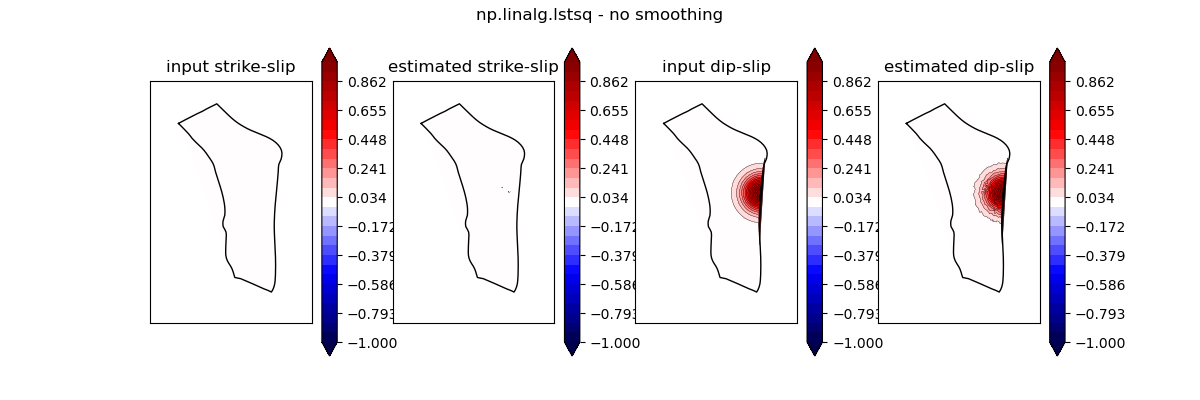

Dip-slip residual = 5.2830230968098375


In [6]:
# Slip estimation with np.linalg.lstsq
slip_distribution_estimated = np.linalg.lstsq(tde_matrix, synthetic_displacements, rcond=None)
plot_slip_distributions(meshes[0], slip_distribution, slip_distribution_estimated[0], suptitle_string="np.linalg.lstsq - no smoothing")
print("Dip-slip residual = " + str(np.sum(np.abs(slip_distribution_dip_slip_true - slip_distribution_estimated[0][1::2]))))

# 2 - Slip estimation with direct inverse and smoothing

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_60132/1538494058.py:12: UserWarning: No contour levels were found within the data range.
  plt.tricontour(triangulation, slip_distribution_input[0::2], colors="k", linewidths=0.25, levels=levels)
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_60132/1538494058.py:24: UserWarning: No contour levels were found within the data range.
  plt.tricontour(triangulation, slip_distribution_estimated[0::2], colors="k", linewidths=0.25, levels=levels)


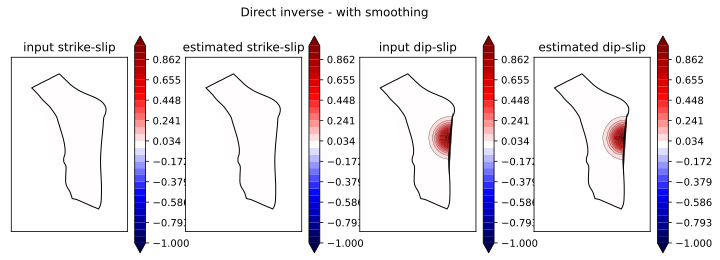

Dip-slip residual = 3.228022542777652


In [9]:
# Slip estimation with direct inverse and smoothing matrix
smoothing_matrix = operators.meshes[0].smoothing_matrix.toarray()
smoothing_matrix = np.delete(smoothing_matrix, np.arange(2, smoothing_matrix.shape[0], 3), axis=0)
smoothing_matrix = np.delete(smoothing_matrix, np.arange(2, smoothing_matrix.shape[1], 3), axis=1)
smoothing_matrix = meshes[0].smoothing_weight * 1e-8 * smoothing_matrix # Weight smoothing matrix
tde_and_smoothing_matrix = np.vstack((tde_matrix, smoothing_matrix))
synthetic_displacements_with_smoothing = np.hstack((synthetic_displacements, np.zeros(smoothing_matrix.shape[0]).T))
slip_distribution_estimated = np.linalg.inv(tde_and_smoothing_matrix.T @ tde_and_smoothing_matrix) @ tde_and_smoothing_matrix.T @ synthetic_displacements_with_smoothing
plot_slip_distributions(meshes[0], slip_distribution, slip_distribution_estimated, suptitle_string="Direct inverse - with smoothing")
print("Dip-slip residual = " + str(np.sum(np.abs(slip_distribution_dip_slip_true - slip_distribution_estimated[1::2]))))


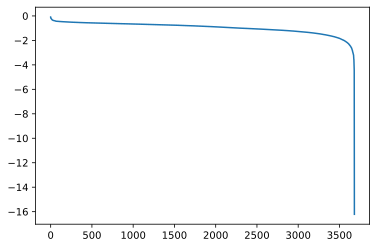

In [56]:
U, S, V = np.linalg.svd(smoothing_matrix)
plt.plot(np.log10(S))
plt.show()

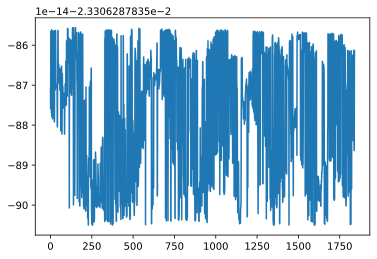

In [62]:
plt.plot(V[-1,1::2])

# Create properly dimensioned distance weighted smoothing matrix - TODO: How to think about reduced dimensions???

In [63]:
def delete_rows_and_columns_from_sparse_csr_matrix(mat, row_indices=[], col_indices=[]):
    """
    Lightly modified from:
    https://stackoverflow.com/questions/13077527/is-there-a-numpy-delete-equivalent-for-sparse-matrices
    Remove the rows (denoted by ``row_indices``) and columns (denoted by ``col_indices``) from the CSR sparse matrix ``mat``.
    WARNING: Indices of altered axes are reset in the returned matrix
    """
    # if not isinstance(mat, csr_matrix):
    #     raise ValueError("works only for CSR format -- use .tocsr() first")

    rows = []
    cols = []
    if any(row_indices):
        rows = list(row_indices)
    if any(col_indices):
        cols = list(col_indices)

    if len(rows) > 0 and len(cols) > 0:
        row_mask = np.ones(mat.shape[0], dtype=bool)
        row_mask[rows] = False
        col_mask = np.ones(mat.shape[1], dtype=bool)
        col_mask[cols] = False
        return mat[row_mask][:,col_mask]
    elif len(rows) > 0:
        mask = np.ones(mat.shape[0], dtype=bool)
        mask[rows] = False
        return mat[mask]
    elif len(cols) > 0:
        mask = np.ones(mat.shape[1], dtype=bool)
        mask[cols] = False
        return mat[:,mask]
    else:
        return mat


def scaled_sigmoid(arr, scalefactor):
    arr = 1 / (1 + np.exp(-arr * scalefactor)) - 0.5
    arr = 2 * arr #  Scale 0-1
    return arr


# Eliminate matrix entries for vertical displacments and tensile slip
smoothing_matrix = copy.deepcopy(operators.meshes[0].smoothing_matrix)
smoothing_matrix = smoothing_matrix.tocsr()
rows_to_delete = np.arange(2, smoothing_matrix.shape[0], 3)
columns_to_delete = np.arange(2, smoothing_matrix.shape[1], 3)
smoothing_matrix = delete_rows_and_columns_from_sparse_csr_matrix(smoothing_matrix, rows_to_delete, columns_to_delete)

# Create simple smoothing matrix without distance weighting

In [64]:
def get_tri_smoothing_matrix_simple(share):
    """
    Produces a smoothing matrix based on the scale-dependent
    umbrella operator (e.g., Desbrun et al., 1999; Resor, 2004).

    Inputs:
    share: n x 3 array of indices of the up to 3 elements sharing a side
        with each of the n elements

    Outputs:
    smoothing matrix: 3n x 3n smoothing matrix
    """

    # Allocate sparse matrix for contructing smoothing matrix
    n_shared_tris = share.shape[0]
    smoothing_matrix = scipy.sparse.lil_matrix((3 * n_shared_tris, 3 * n_shared_tris))

    # Place the weights into the smoothing operator
    # TODO: Replace 3 with n_slip_dimensions
    for j in range(3):
        for i in range(n_shared_tris):
            smoothing_matrix[3 * i + j, 3 * i + j] = 3
            if share[i, j] != -1:
                k = 3 * i + np.array([0, 1, 2])
                m = 3 * share[i, j] + np.array([0, 1, 2])
                smoothing_matrix[k, m] = -1
    return smoothing_matrix

share = celeri.get_shared_sides(meshes[0].verts)
smoothing_matrix_simple = get_tri_smoothing_matrix_simple(share)

# smoothing_matrix = copy.deepcopy(meshes[0].smoothing_matrix)
smoothing_matrix_simple = smoothing_matrix_simple.tocsr()
rows_to_delete = np.arange(2, smoothing_matrix_simple.shape[0], 3)
columns_to_delete = np.arange(2, smoothing_matrix_simple.shape[1], 3)
smoothing_matrix_simple = delete_rows_and_columns_from_sparse_csr_matrix(smoothing_matrix_simple, rows_to_delete, columns_to_delete)

# Loveless style resolution scaling
resolution_vector = np.sum(tde_matrix ** 2, axis=0).T
resolution_vector_scaled = scaled_sigmoid(resolution_vector, 1e4)
resolution_matrix_scaled = scipy.sparse.diags(1.0 / resolution_vector_scaled)
# smoothing_matrix_simple_resolution_scaled = smoothing_matrix_simple * np.matlib.repmat(resolution_vector, smoothing_matrix_simple.shape[0], 1)
# smoothing_matrix_simple_resolution_scaled = smoothing_matrix_simple * np.matlib.repmat(resolution_vector_scaled, smoothing_matrix_simple.shape[0], 1)

smoothing_matrix_simple_resolution_scaled = smoothing_matrix_simple.toarray() * resolution_vector_scaled[:, np.newaxis]
print(smoothing_matrix_simple_resolution_scaled.shape)
smoothing_matrix_simple_resolution_scaled = scipy.sparse.lil_matrix(smoothing_matrix_simple_resolution_scaled)
print(smoothing_matrix_simple_resolution_scaled.shape)

# smoothing_matrix_simple_resolution_scaled = smoothing_matrix_simple * resolution_matrix_scaled # I'm only scaling the diagonal here
# TODO: Fix resolution matrix: Divide each row by the corresponding element of diagonal of resolution_vector_scaled.



(3682, 3682)
(3682, 3682)


# 3 - Attempt at slip estimation with one of the apparently reasonable set of eigenvectors

In [98]:
oen = meshes[0].ordered_edge_nodes[:,0]
xs = 2 * np.pi * np.arange(oen.shape[0]).astype(np.float64) / oen.shape[0]

In [135]:
one_ss = np.zeros(tde_matrix.shape[1])
one_ds = one_ss.copy()
one_ss[0::2] = 1
one_ds[1::2] = 1
boundary_basis = [one_ss, one_ds]
for i in range(1, 10):
    for f in [np.cos(i * xs), np.sin(i * xs)]:
        ss = np.zeros(tde_matrix.shape[1])
        ds = np.zeros(tde_matrix.shape[1])
        count = np.zeros(tde_matrix.shape[1]//2)
        for v_idx, v in enumerate(oen):
            tris = np.where(meshes[0].verts == v)[0]
            ss[2*tris] += f[v_idx]
            ds[2*tris+1] += f[v_idx]
            count[tris] += 1
        ss.reshape((-1, 2))[(count != 0)] /= count[count != 0, None]
        ds.reshape((-1, 2))[(count != 0)] /= count[count != 0, None]
        boundary_basis.append(ss)
        boundary_basis.append(ds)
boundary_basis = np.array(boundary_basis).T.copy()

In [136]:
boundary_basis.shape

(3682, 38)

In [137]:
n_eigenvalues = 50
_, eigenvectors = scipy.sparse.linalg.eigsh(smoothing_matrix_simple, n_eigenvalues, which="SM")
eigenvectors = np.concatenate((eigenvectors, boundary_basis), axis=1)

In [138]:
eigenvectors.shape

(3682, 88)

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_60132/1538494058.py:12: UserWarning: No contour levels were found within the data range.
  plt.tricontour(triangulation, slip_distribution_input[0::2], colors="k", linewidths=0.25, levels=levels)


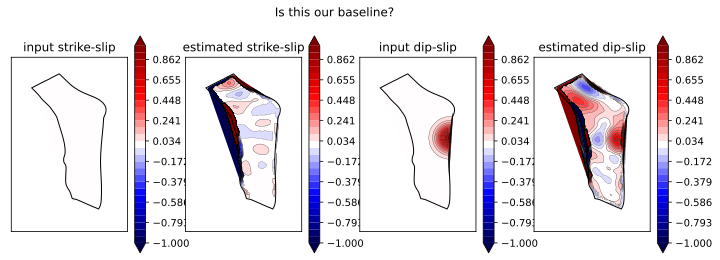

Dip-slip residual = 608.1866296149814


In [139]:

# show_modes(meshes[0], eigenvectors, r"""scipy.sparse.linalg.eigsh(smoothing_matrix_simple, n_eigenvalues, which="SM")""")
eigenvector_weights_estimated = np.linalg.pinv(tde_matrix @ eigenvectors) @ synthetic_displacements # Solve for eigenvector weights
slip_distribution_estimated = eigenvectors @ eigenvector_weights_estimated # Recover slip from eigenvector weights
plot_slip_distributions(meshes[0], slip_distribution, slip_distribution_estimated, suptitle_string="Is this our baseline?")
print("Dip-slip residual = " + str(np.sum(np.abs(slip_distribution_dip_slip_true - slip_distribution_estimated[1::2]))))

# 4 - Eigenvectors with decoupled the strike- and dip-slip


/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_44900/1538494058.py:12: UserWarning: No contour levels were found within the data range.
  plt.tricontour(triangulation, slip_distribution_input[0::2], colors="k", linewidths=0.25, levels=levels)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
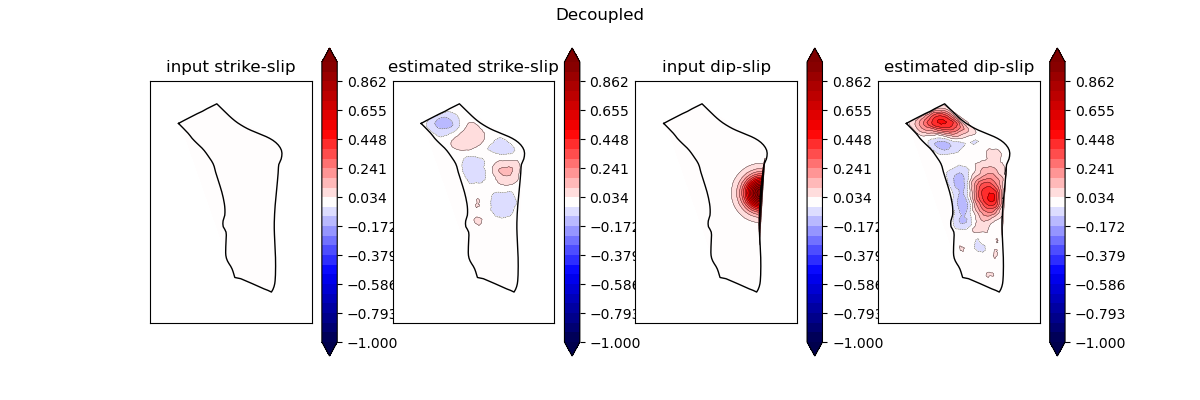

Dip-slip residual = 156.925731442179


In [98]:
n_eigenvalues = 30
_, eigenvectors = scipy.sparse.linalg.eigsh(smoothing_matrix_simple, n_eigenvalues, which="SM")
# show_modes(meshes[0], eigenvectors, r"""scipy.sparse.linalg.eigsh(smoothing_matrix_simple, n_eigenvalues, which="SM") -- reduced""")
eigenvectors_checkerboard = np.zeros((2 * meshes[0].n_tde, 2 * n_eigenvalues))
eigenvectors_checkerboard[0::2, 0::2] = eigenvectors[0::2, :]
eigenvectors_checkerboard[1::2, 1::2] = eigenvectors[1::2, :]
eigenvector_weights_estimated = np.linalg.pinv(tde_matrix @ eigenvectors_checkerboard) @ synthetic_displacements # Solve for eigenvector weights
slip_distribution_estimated = eigenvectors_checkerboard @ eigenvector_weights_estimated # Recover slip from eigenvector weights
plot_slip_distributions(meshes[0], slip_distribution, slip_distribution_estimated, suptitle_string="Decoupled")
print("Dip-slip residual = " + str(np.sum(np.abs(slip_distribution_dip_slip_true - slip_distribution_estimated[1::2]))))


In [91]:
# TODO: Visualize the matrices that are being inverted each case (single figure?)

# Loop over number of eigenvalues and calculate residual

In [67]:
np.mean(meshes[0].centroids[:, 1])

45.55396823737099